In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from sklearn.preprocessing import MinMaxScaler
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

C:\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
class synthesis_scheme():
    
    def _init_(self):
        c1 = 0
        c2 = 0
        cad = 0
        heat = 0
        autoclave = 0
        r1 = 'None'
        r2 = 'None'
        solvent = 'None'
        add_to_solvent = 'None'
        return
    
    def __str__(self):
        out = 'R1: ' + str(self.r1) + '\n' + \
            'C1: ' + str(self.c1) + '\n' + \
            'R2: ' + str(self.r2) + '\n' + \
            'C2: ' + str(self.c2) + '\n' + \
            'Solvent: ' + self.solvent + '\n' + \
            'Add to solvent: ' + self.add_to_solvent + '\n' + \
            'Cad: ' + str(self.cad) + '\n' + \
            'Heat: ' + str(self.heat) + '\n' + \
            'Autoclave: ' + str(int(self.autoclave)) + '\n'
            
        return out
                

In [32]:
class nanozymes_synthesis():
    
    def _init_(self):
        return
        
    
    def load(self,
             sourse_data, #='nanozymes.xlsx',
             target_data, #='nanozymes_add.xlsx',
             voc_formulas, #='nanozymes_formulas.xlsx',
             voc_reactions, #='reaction_types.xlsx',
             voc_reagents,
             voc_solvents,
             voc_solvents_add
            ):
        
        self.df_main = pd.read_excel(sourse_data, index_col=0, usecols=['index',
                                                                        'formula',
                                                                        'length, nm',
                                                                        'width, nm',
                                                                        'depth, nm',
                                                                        'Km, mM'])
        #self.df_rtypes = pd.read_excel(voc_reactions, index_col=0)
        self.df_formulas = pd.read_excel(voc_formulas, index_col=0)
        self.df_add = pd.read_excel(target_data, usecols=['Индекс',
                                                            'R1',
                                                            'R2',
                                                            'solvent',
                                                            'C1',
                                                            'C2',
                                                            'add to solvent',
                                                            'Сad',
                                                            'heat',
                                                            'autoclave'])
        self.df_rs = pd.read_excel(voc_reagents, index_col=None)
        self.df_solvents = pd.read_excel(voc_solvents, index_col=None)
        self.df_solvents_add = pd.read_excel(voc_solvents_add, index_col=None)
        
        return
        
        
    def _prepare_main(self, df):
    
        df['length, nm'].fillna(0, inplace=True)
        df['width, nm'].fillna(0, inplace=True)
        df['depth, nm'].fillna(0, inplace=True)
    
        df['Km, mM'] = pd.to_numeric(df['Km, mM'], errors='coerce')   
        df['Km, mM'].fillna(0, inplace=True)

        #scaling
        #df['Vmax, mM/s'] = df['Vmax, mM/s'] * 1000.
        #df['Ccat(mg/mL)'] = df['Ccat(mg/mL)'] * 1000.        
        
        return df
    
    def preprocessing(self):
        
        self._prepare_main(self.df_main)
        self.build_merged_data()
                
        return
        
    def build_merged_data(self):
        
        df_main_merged = self.df_main.merge(self.df_formulas, left_on='formula', right_on='formula', how='left')
        
        df_merged = self.df_add.merge(self.df_rs, left_on='R1', right_on='formula', how='inner', suffixes=(None,'_r1'))
        
        df_merged = df_merged.merge(self.df_rs, left_on='R2', right_on='formula', how='inner', suffixes=(None,'_r2'))
        df_merged = df_merged.merge(self.df_solvents, left_on='solvent', right_on='formula', how='inner', suffixes=(None,'_solvent'))
        df_merged = df_merged.merge(self.df_solvents_add, left_on='add to solvent', right_on='formula', how='inner', suffixes=(None,'_add_to_solvent'))
        
        df_merged.set_index('Индекс', inplace=True)
        df_merged = df_merged.drop(columns=['R1','R2', 'solvent', 'add to solvent',
                                            'formula', 'dec_ord', 'r_all', 'formula_r2', 'dec_ord_r2', 'r_all_r2',
                                            'formula_solvent', 'dec_ord_solvent','r_all_solvent',
                                            'formula_add_to_solvent','dec_ord_add_to_solvent','r_all_add_to_solvent',
                                            #'Индекс'
                                           ])
        df_main_merged.to_excel('main_merged.xlsx')
        df_merged.to_excel('merged.xlsx')
        self.df_all = df_main_merged.merge(df_merged, left_index=True, right_index=True, how='inner')
        #self.df_all.to_excel('temp.xlsx')
        #self.df_dummies = pd.get_dummies(df_all)

        self.columns_source = [
                           'length, nm', 'width, nm', 'depth, nm',
                           'formula_0', 'formula_1', 'formula_2', 'formula_3', 'formula_4',
                           'formula_5', 'formula_6', 'formula_7', 'formula_8'
                         ]
        self.columns_target = ['C1','C2', 'Сad', 'heat', 'autoclave',
                          'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6',
                          'r_0_r2', 'r_1_r2', 'r_2_r2', 'r_3_r2', 'r_4_r2', 'r_5_r2',
                          'r_6_r2', 'r_0_solvent', 'r_1_solvent', 'r_2_solvent',
                          'r_3_solvent', 'r_4_solvent',
                          'r_0_add_to_solvent', 'r_1_add_to_solvent', 'r_2_add_to_solvent',
                          'r_3_add_to_solvent', 'r_4_add_to_solvent', 'r_5_add_to_solvent'
                         ]
               
        return

    def model_linear(self, inp_len, out_len):

        input = Input(inp_len)
        inner_1 = Dense(out_len)(input)
        inner_1 = Activation('elu')(inner_1)
        inner_2 = Dense(out_len)(inner_1)
        inner_2 = Activation('elu')(inner_2)
        inner_3 = Dense(out_len)(inner_2)
        inner_3 = Activation('elu')(inner_3)
        inner_4 = Dense(inp_len*3)(inner_3)
        inner_4 = Activation('elu')(inner_4)        
        inner_5 = Dense(inp_len*2)(inner_4)
        inner_5 = Activation('elu')(inner_5)        
        out = Dense(out_len)(inner_3)
        out = Activation('relu')(out)

        model = Model(input, out)
        model.summary()

        return model    

    def plot_history(self):
        
        plt.plot(self.history.history['loss'], label='train loss')
        plt.plot(self.history.history['val_loss'], label='val loss')
        plt.legend()
        plt.show()
        
        return
    
    def train(self, lr, epochs):
        
        inp_len = len(self.columns_source)
        out_len = len(self.columns_target)
        
        df_input = self.df_all[self.columns_source].to_numpy()
        df_target = self.df_all[self.columns_target].to_numpy()
        
        X_train, X_test, Y_train, Y_test = train_test_split(df_input, df_target,
                                                    test_size=0.2, random_state=42)
        self.X_train = X_train
        
        self.X_scaler = MinMaxScaler()

        X_train_scaled = self.X_scaler.fit_transform(X_train)
        X_test_scaled = self.X_scaler.transform(X_test)

        
        joblib.dump(self.X_scaler, 'x_scaler')

        self.model = self.model_linear(inp_len, out_len)
        self.model.compile(optimizer=Adamax(learning_rate=lr), loss='mae')
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=5)
        
        self.history = self.model.fit(X_train_scaled, Y_train,
                                       epochs=epochs,
                                       #callbacks=[reduce_lr],
                                       validation_data=(X_test_scaled, Y_test),
                                       batch_size=1)
        
        
        return self.history
    
    def predict(self, data):
        
        data_scaled = self.X_scaler.transform(data)
        out = self.model.predict(data_scaled)

        out = out[0]
        self.out = out
        
        res = synthesis_scheme()        
        res.c1 = out[0]
        res.c2 = out[1]
        res.cad = out[2]
        res.heat = out[3]       
        res.autoclave = 1 if out[4]>=0.5 else 0
        res.r1 = self._get_rname(out[5:12])
        res.r2 = self._get_rname(out[12:19])
        res.solvent = self._get_solventsname(out[19:24])
        res.add_to_solvent = self._get_solventsaddname(out[24:30])
               
        return res
    
    def _get_rname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_rs[self.df_rs.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res

    def _get_solventsname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_solvents[self.df_solvents.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res    

    def _get_solventsaddname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_solvents_add[self.df_solvents_add.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res    
    
    
    def _get_nanozymesmname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_formulas[self.df_formulas.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res

    def _get_rtypesname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_rtypes[self.df_rtypes.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res

    def encode_nanozymes(self, formula):
        
        res = np.array([
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,2],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,3],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,4],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,5],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,6],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,7],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,8],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,9],
                        (self.df_formulas[self.df_formulas.index == formula].to_numpy())[0,10]
                     ])
        return res    
    
    def model_save(self, model_path):
        
        self.model.save(model_path)
        
        return
    
    def model_load(self, model_path, scaler_file):
        
        self.model = tf.keras.models.load_model(model_path)
        self.X_scaler = joblib.load(scaler_file)
        
        return
    
            



In [33]:
ns = nanozymes_synthesis()
ns.load('peroxidase.xlsx',
        'nanozymes_add.xlsx',
        'nanozymes_formulas.xlsx',
        'reaction_types.xlsx',
        'Rs.xlsx',
        'solvents.xlsx',
        'solvents_add.xlsx'
       )
ns.preprocessing()
ns.train(1e-4, 300)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_48 (Dense)            (None, 30)                390       
                                                                 
 activation_48 (Activation)  (None, 30)                0         
                                                                 
 dense_49 (Dense)            (None, 30)                930       
                                                                 
 activation_49 (Activation)  (None, 30)                0         
                                                                 
 dense_50 (Dense)            (None, 30)                930       
                                                                 
 activation_50 (Activation)  (None, 30)                0   

247/247 [==============================] - 2s 9ms/step - loss: 2.4240 - val_loss: 2.2270
Epoch 145/300
247/247 [==============================] - 2s 10ms/step - loss: 2.4242 - val_loss: 2.2271
Epoch 146/300
247/247 [==============================] - 2s 9ms/step - loss: 2.4236 - val_loss: 2.2257
Epoch 147/300
247/247 [==============================] - 2s 9ms/step - loss: 2.4235 - val_loss: 2.2219
Epoch 148/300
247/247 [==============================] - 5s 19ms/step - loss: 2.4225 - val_loss: 2.2210
Epoch 149/300
247/247 [==============================] - 3s 12ms/step - loss: 2.4215 - val_loss: 2.2200
Epoch 150/300
247/247 [==============================] - 2s 10ms/step - loss: 2.4200 - val_loss: 2.2201
Epoch 151/300
247/247 [==============================] - 2s 9ms/step - loss: 2.4190 - val_loss: 2.2179
Epoch 152/300
247/247 [==============================] - 3s 11ms/step - loss: 2.4190 - val_loss: 2.2182
Epoch 153/300
247/247 [==============================] - 2s 9ms/step - loss: 2.417

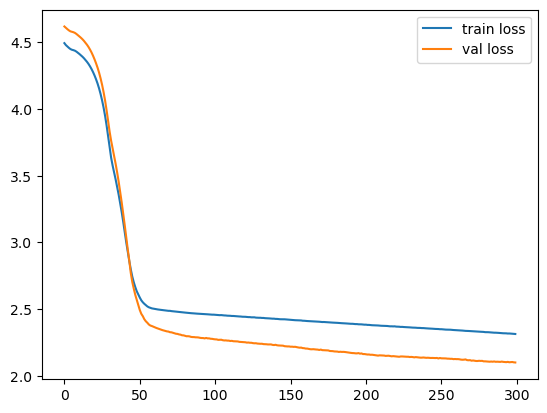

In [34]:
ns.plot_history()

In [6]:
ns.model_save('saved')

INFO:tensorflow:Assets written to: saved\assets


In [111]:
ns.model_load('saved', 'x_scaler')

In [31]:
ns.model_save('modfel.h5')